In [2]:
from utils import AverageMeter, load_inputs, get_png_names, get_ys
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, utils, models
from model import RecurrentAttention
import torch.nn.functional as F
import matplotlib.pyplot as plt
from config import get_config
from trainer import Trainer
from PIL import Image
from tqdm import tqdm
import pandas as pd
import torchvision
import shutil
import pickle
import torch
import utils
import json
import time

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [7]:
m = open("../../pooling/data/migration_data.json",)
mig_data = json.load(m)
m.close()
mig_data = pd.DataFrame.from_dict(mig_data, orient = 'index').reset_index()
mig_data.columns = ['muni_id', 'num_migrants']
q = 4
mig_data['class'] = pd.qcut(mig_data['num_migrants'], q = q, labels = [i for i in range(q)])
mig_data

,muni_id,num_migrants,class
0,484001001,42055.0,3
1,484001002,4017.0,3
2,484001003,11992.0,3
3,484001004,762.0,2
4,484001005,7551.0,3
...,...,...,...
2326,484032049,2487.0,3
2327,484032050,2024.0,3
2328,484032051,3084.0,3
2329,484032052,2919.0,3


In [8]:
mig_data['class'].value_counts()

0    583
1    583
2    583
3    582
Name: class, dtype: int64

In [9]:
image_names = get_png_names("../../pooling/data/MEX/")

y_class, y_mig = get_ys(image_names, mig_data)

In [10]:
import matplotlib.pyplot as plt
import torchvision

In [11]:
import random

train_num = int(25 * .70)

train_indices = random.sample(range(0, 25), train_num)
val_indices = [i for i in range(0, 25) if i not in train_indices]

In [12]:
import numpy as np
from utils import plot_images

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [36]:
class miniConv(torch.nn.Module):
    
    def __init__(self, resnet):
        super().__init__()
        
        self.conv1_miniConv = resnet.conv1
        self.bn1_miniConv = resnet.bn1
        self.relu_miniConv = resnet.relu
        self.maxpool_miniConv = resnet.maxpool
        self.layer1_miniConv = resnet.layer1
        self.layer2_miniConv = resnet.layer2
        self.layer3_miniConv = resnet.layer3
        self.layer4_miniConv = resnet.layer4
        self.adp_pool_miniConv = torch.nn.AdaptiveAvgPool3d((512, 7, 7))
        
        D_in = 1 * 512 * 7 * 7
        h_g = 512
        self.fc1 = torch.nn.Linear(D_in, h_g)#.to('cuda:1')
        
    def forward(self, phi):
        
        phi = self.conv1_miniConv(phi)
        phi = self.bn1_miniConv(phi)
        phi = self.relu_miniConv(phi)
        phi = self.maxpool_miniConv(phi)
        phi = self.layer1_miniConv(phi)
        phi = self.layer2_miniConv(phi)
        phi = self.layer3_miniConv(phi)
        phi = self.layer4_miniConv(phi)
        phi = self.adp_pool_miniConv(phi)
        phi = phi.flatten(start_dim = 1)  
        phi = self.fc1(phi)
        return phi
    

In [52]:
resnet = torchvision.models.resnet18()
miniConv_model = miniConv(resnet = resnet)

# params = []
# for n,p in miniConv_model.named_parameters():
#     print(n)
#     params.append(n)

In [38]:
# checkpoint = torch.load("./ckpt_og/ram_4_50x50_0.75_model_best.pth.tar")
# checkpoint = checkpoint["model_state"]
# checkpoint.keys()

In [39]:
# [p for p in list(checkpoint.keys()) if "_miniConv" in p]

In [46]:
# matching_keys2

In [55]:
checkpoint = torch.load("./ckpt/ram_4_50x50_0.75_model_best.pth.tar")
checkpoint = checkpoint["model_state"]

matching_keys = [p for p in list(checkpoint.keys()) if "_miniConv" in p]
matching_keys2 = [p for p in list(checkpoint.keys()) if p == 'sensor.fc1.weight' or p == 'sensor.fc1.bias']
[matching_keys2.append(k) for k in matching_keys]

weights = {}
for mk in matching_keys2:
    miniConv_model_key = mk.replace("sensor.", "")
    weights[miniConv_model_key] = checkpoint[mk]
    
miniConv_model.load_state_dict(weights)

<All keys matched successfully>

In [58]:
g = open("./locations_extract.json")
glimpses = json.load(g)
g.close()

In [94]:
# glimpses

484001008
torch.Size([1, 3, 881, 570])
torch.Size([1, 3, 114, 114])
torch.Size([1, 3, 114, 114])
torch.Size([1, 3, 114, 114])
torch.Size([1, 3, 114, 114])


484004004
torch.Size([1, 3, 1320, 2383])
torch.Size([1, 3, 264, 264])
torch.Size([1, 3, 264, 264])
torch.Size([1, 3, 264, 264])
torch.Size([1, 3, 264, 264])


484004001
torch.Size([1, 3, 2732, 2448])
torch.Size([1, 3, 489, 489])
torch.Size([1, 3, 489, 489])
torch.Size([1, 3, 489, 489])
torch.Size([1, 3, 489, 489])


484005010
torch.Size([1, 3, 1092, 1368])
torch.Size([1, 3, 218, 218])
torch.Size([1, 3, 218, 218])
torch.Size([1, 3, 218, 218])
torch.Size([1, 3, 218, 218])


484001005
torch.Size([1, 3, 953, 1241])
torch.Size([1, 3, 190, 190])
torch.Size([1, 3, 190, 190])
torch.Size([1, 3, 190, 190])
torch.Size([1, 3, 190, 190])


484001007
torch.Size([1, 3, 1341, 1261])
torch.Size([1, 3, 252, 252])
torch.Size([1, 3, 252, 252])


KeyboardInterrupt: 

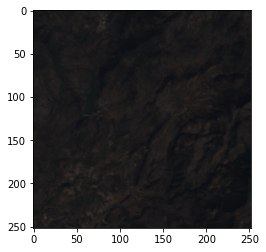

In [59]:
features_dict = {}

for im_name, patches in glimpses.items():
        
    muni_id = im_name.split("/")[5]
    
    print(muni_id)
    
    image = load_inputs(im_name)
    
    print(image.shape)
    
    cur_features_dict = {}

    for glimpseID, coords in patches.items():
            
        from_x, to_x, from_y, to_y = int(coords["from_x"]), int(coords["to_x"]), int(coords["from_y"]), int(coords["to_y"])
                
        cur_patch = image[:, :, from_x:to_x, from_y:to_y]
        
#         print(.shape)
        
        plt.imshow(cur_patch[0].permute(1,2,0))
        plt.savefig(f"{muni_id}_{glimpseID}.png")
        
        print(cur_patch.shape)
        
        features = miniConv_model(cur_patch)[0].detach().numpy()
        features = [str(f) for f in features]
        
        cur_features_dict[glimpseID] = features

    features_dict[im_name] = cur_features_dict
        
    print("\n")
    
    
#     print(image.shape)
    
#     print(v, "\n")

In [60]:
features_dict

{'../../attn/data/MEX/484001008/pngs/484001008_2010_all_box484001008_MAY.png': {'glimpse0': ['-44.88124',
   '-39.92961',
   '221.50955',
   '-34.240314',
   '-33.833168',
   '-31.659412',
   '-36.741894',
   '-9.048515',
   '-37.73855',
   '-31.947834',
   '-4.4747167',
   '-27.681953',
   '-34.825977',
   '-86.80033',
   '-17.73956',
   '-35.69273',
   '-16.610807',
   '-8.130311',
   '-38.442776',
   '-14.94148',
   '-37.167625',
   '-36.84255',
   '-15.255919',
   '-7.2356253',
   '-13.500128',
   '-38.32555',
   '-10.28603',
   '-32.936977',
   '-37.20842',
   '-38.209892',
   '-21.926714',
   '-22.633228',
   '-16.519236',
   '-33.14192',
   '-61.73199',
   '-34.47637',
   '-36.944942',
   '-25.73253',
   '-7.091854',
   '-32.857883',
   '-9.381997',
   '-42.37945',
   '-34.4636',
   '-35.739',
   '-21.124607',
   '-38.819756',
   '-38.16056',
   '-37.079376',
   '-27.251635',
   '-33.787388',
   '-57.498173',
   '-26.584455',
   '-40.772465',
   '439.22916',
   '-22.900564',
   

In [73]:
# cur_features_dict["glimpse0"]

In [74]:
with open("sample_features.json", "w") as outfile: 
    json.dump(features_dict, outfile)